## Cleaning

In [119]:
import pandas as pd
from tqdm import tqdm

filename = 'twitter_cs'

twcs: pd.DataFrame = pd.read_csv(f'data/{filename}.csv', nrows=100_000)
twcs = twcs.sort_values('created_at')
twcs.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
24666,31297,122902,True,Fri Apr 28 15:30:08 +0000 2017,Dear @marksandspencer this is the laugh of the...,31296,NaN
24665,31296,marksandspencer,False,Fri Apr 28 17:03:28 +0000 2017,"@122902 Which store have you seen this in, Mur...",31294,31297.0
24664,31294,122902,True,Fri Apr 28 17:15:00 +0000 2017,@marksandspencer Doha festival city,31292,31296.0
24661,31292,marksandspencer,False,Fri Apr 28 18:49:04 +0000 2017,@122902 We've mentioned this to our Internatio...,31293,31294.0
83300,106447,121761,True,Fri Dec 01 00:00:05 +0000 2017,@SW_Help @128411 @121204 @GWRHelp How many peo...,106449,106445.0


In [120]:
twcs["text"] = (
    twcs["text"]
    .str.replace(r"^\s*@[^ ]*", "", regex=True)
    .str.replace(r"https?:\/\/[^\s\\n]+", "", regex=True)
    .str.replace(r"\n+", ' ', regex=True)
    .str.strip()
)
twcs = twcs.rename(columns={'inbound': 'is_customer'})

### Make threads

In [121]:
def find_root(tweet_id, df):
    parent_id = tweet_id

    while True:
        potential_parent = df[df['in_response_to_tweet_id'] == parent_id]['tweet_id']

        if len(potential_parent) == 0:
            return parent_id
        
        parent_id = potential_parent.values[0]

tqdm.pandas(desc="Making threads...")
twcs['thread_id'] = twcs['tweet_id'].progress_apply(lambda x: find_root(x, twcs))

Making threads...: 100%|██████████| 100000/100000 [00:25<00:00, 3857.55it/s]


### Aggregate to chats

In [122]:
def group_conversations(df):
    altnerating_messages = []
    prev_is_customer = None

    for _, row in df.iterrows():
        is_customer = row['is_customer']

        if prev_is_customer is None and not is_customer: # Always start with a customer message
            continue
        elif prev_is_customer == is_customer:
            altnerating_messages[-1] += ' ' + row['text']
        else:
            altnerating_messages.append(row['text'])
            prev_is_customer = is_customer

    return altnerating_messages

chats_df = twcs.copy()
tqdm.pandas(desc="Grouping conversations...")
chats_df['chat'] = chats_df.progress_apply(lambda x: group_conversations(twcs[twcs['thread_id'] == x['thread_id']]), axis=1)
chats_df = chats_df.drop_duplicates('thread_id')[['chat']]
chats_df['n_messages'] = chats_df['chat'].apply(lambda x: len(x))

Grouping conversations...:   0%|          | 0/100000 [00:00<?, ?it/s]

Grouping conversations...: 100%|██████████| 100000/100000 [00:17<00:00, 5826.80it/s]


### Filter

In [123]:
proper_length = chats_df['n_messages'] >= 4
non_dm = chats_df['chat'].apply(lambda c: all([' dm' not in m.lower() for m in c]))

chats_df = chats_df[proper_length & non_dm]
print(f"Found {len(chats_df)} fitting chats")

Found 5597 fitting chats


## Augmentation

### Embed random question

In [124]:
import numpy as np

def random_customer_idx(x):
    even = [i for i in range(0, x - 2, 2)] # Don't pick the last message
    return np.random.choice(even)

chats_df['aug_idx'] = chats_df['n_messages'].apply(lambda x: random_customer_idx(x))
chats_df['aug_text'] = chats_df.apply(lambda x: x['chat'][x['aug_idx']], axis=1)

In [125]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer(
    # "mixedbread-ai/mxbai-embed-large-v1"
    "TaylorAI/bge-micro-v2"
)

to_embed = chats_df['aug_text'].tolist()
embeddings = model.encode(to_embed, show_progress_bar=True)
chats_df['aug_embedding'] = embeddings.tolist()

Batches: 100%|██████████| 175/175 [00:08<00:00, 19.50it/s]


### Cluster questions

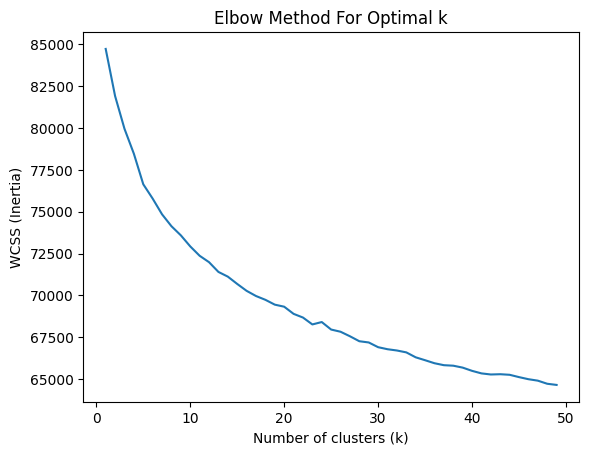

In [126]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

ks = [i for i in range(1, 50, 1)]
wcss = []

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(embeddings)
    wcss.append(kmeans.inertia_)


plt.plot(ks, wcss)

plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Inertia)')

plt.show()

In [127]:
k = 20

kmeans = KMeans(n_clusters=k, random_state=0).fit(embeddings)
chats_df['cluster'] = kmeans.labels_

### Creating augmented data

In [128]:
def substitue_sim_answer(row, df):
    same_cluster  = df[df['cluster'] == row['cluster']]

    sub = same_cluster.loc[np.random.choice(same_cluster.index)]
    sub_chat, sub_aug_idx= sub['chat'], sub['aug_idx']
    sub_answer = sub_chat[sub_aug_idx + 1]

    orig_chat, orig_aug_idx = row['chat'], row['aug_idx']
    aug_chat = orig_chat[:orig_aug_idx + 1] + [sub_answer] + orig_chat[orig_aug_idx + 2:]

    return aug_chat



chats_df['aug_chat'] = chats_df.progress_apply(lambda x: substitue_sim_answer(x, chats_df), axis=1)

Grouping conversations...:   0%|          | 0/5597 [00:00<?, ?it/s]

Grouping conversations...: 100%|██████████| 5597/5597 [00:00<00:00, 6703.17it/s]


In [129]:
chats = np.array(chats_df[['chat', 'aug_chat']].values)

to_shuffle = np.random.rand(len(chats)) > 0.5

labels = np.where(to_shuffle, -1, 1)

to_shuffle = np.column_stack((to_shuffle, to_shuffle))
shuffled_chats = np.where(to_shuffle, chats[:, ::-1], chats)

## Construcing graph

### Nodes

In [130]:
import torch

torch.save(shuffled_chats, f"data/{filename}_nodes.pt")

### Labels

In [131]:
torch.save(labels, f"data/{filename}_labels.pt")

### Edges

In [132]:
from torch import Tensor

def create_chat_graph(chat):
    human_idxs = [i for i in range(0, len(chat), 2)]

    chat_edges = []
    chat_edges_idxs = []
    for ui in range(len(chat)):
        for uj in range(len(chat)):
            if ui == uj:
                edge_type = [True, False, False, False]
            else:
                edge_type = [
                    False,
                    ui > uj,
                    ui in human_idxs,
                    uj in human_idxs,
                ]

            edge_type = sum(2**i for i, v in enumerate(reversed(edge_type)) if v)

            chat_edges_idxs.append((ui, uj))
            chat_edges.append(edge_type)
    
    return chat_edges, chat_edges_idxs


edges = []
edge_idxs = []
for c1, c2 in shuffled_chats:
   c1_edges, c1_edge_idxs = create_chat_graph(c1)
   c2_edges, c2_edge_idxs = create_chat_graph(c2)

   edges.append(Tensor([c1_edges, c2_edges]).to(torch.int8))
   edge_idxs.append(Tensor([c1_edge_idxs, c2_edge_idxs]).T.long())

torch.save(edges, f"data/{filename}_edges.pt")
torch.save(edge_idxs, f"data/{filename}_edge_idxs.pt")